# Artificial dataset generation

In [1]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2019_02_21', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports

In [2]:
# Standard lib imports
import os
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

# Nanocompore simulator
from nanocompore.Simulator import simulate_reads_from_fasta

## Generate reads

### Test on single ref + plot

Write log file
Import RNA model file
Read Fasta file and simulate corresponding data
Process reference ref_0001
	Try to find 28 kmers to modify
	Found valid combination for 24 kmers
	modified positions: [  5  60  74  80 107 120 128 184 200 216 236 262 272 290 339 350 358 377
 385 398 416 443 475 492]
All done


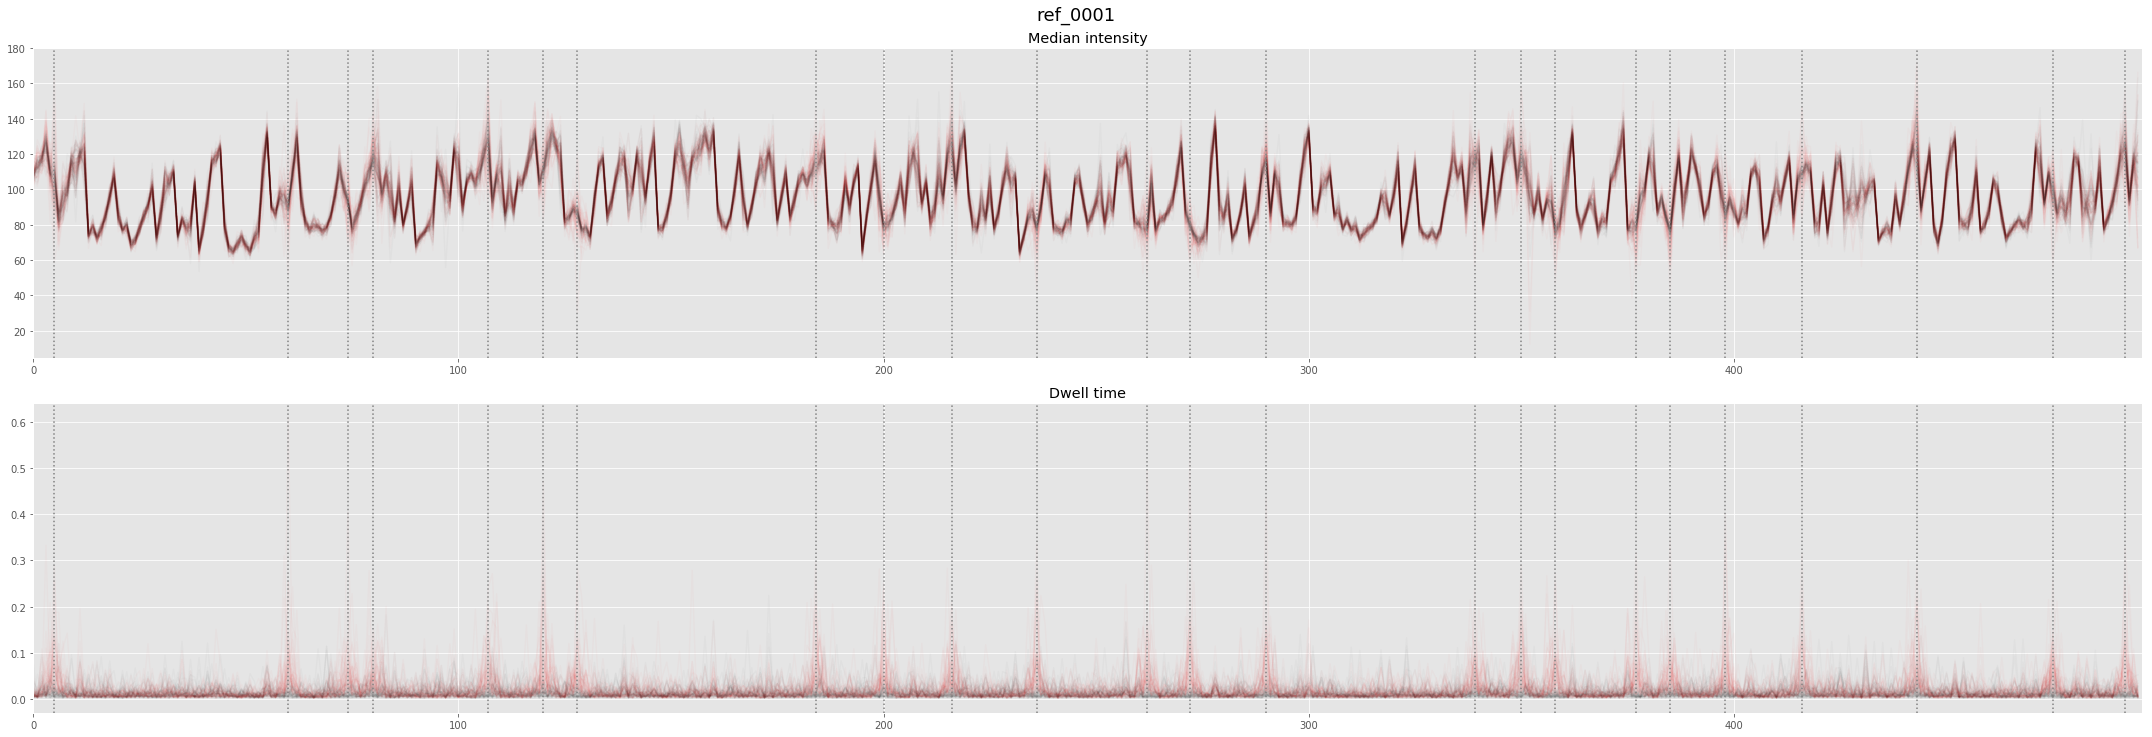

In [13]:
simulate_reads_from_fasta (fasta_fn="data/references/random_guided_weight.fa", outpath="data/artificial_datasets/", ref_list=["ref_0001"], log_level="debug", plot=True, mod_reads_freq=0.5, mod_bases_freq=0.20, intensity_mod_scale=5, dwell_mod_scale=0.05, mod_extend_context=2)

### Generate all read datasets

In [5]:
bash(virtualenv="Python3.6", cmd="nanocompore simulate_reads -h")

usage: nanocompore simulate_reads [-h] --fasta FASTA [--run_type RUN_TYPE]
                                  [--outpath OUTPATH] [--prefix PREFIX]
                                  [--nreads_per_ref NREADS_PER_REF]
                                  [--intensity_mod_loc INTENSITY_MOD_LOC]
                                  [--intensity_mod_scale INTENSITY_MOD_SCALE]
                                  [--dwell_mod_loc DWELL_MOD_LOC]
                                  [--dwell_mod_scale DWELL_MOD_SCALE]
                                  [--mod_reads_freq MOD_READS_FREQ]
                                  [--mod_bases_freq MOD_BASES_FREQ]
                                  [--mod_bases_type MOD_BASES_TYPE]
                                  [--mod_extend_context MOD_EXTEND_CONTEXT]
                                  [--min_mod_dist MIN_MOD_DIST]
                                  [--rand_seed RAND_SEED]
                                  [--log_level {warning,info,debug}]

Simulate a NanopolishComp

In [155]:
# Options
fasta = "data/references/random_guided_weight.fa"
nreads_per_ref = 100
mod_bases_freq = 0.25
mod_bases_type = "A"
mod_extend_context = 2
min_mod_dist = 6
rand_seed = 42
log_level = "warning"
dwell_mod_loc_list = [0, 0.0001, 0.001, 0.01, 0,1]
intensity_mod_loc_list = [0, 0.01, 0.1, 1, 10]
mod_reads_freq_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Create directory for results
data_dir = "data/artificial_datasets/"
rmtree (data_dir, ignore_errors=True)
mkdir (data_dir)

# Generate datasets
index_fn = os.path.join(data_dir, "datasets_index.tsv")
i = 0
with open (index_fn, "w") as fp:
    fp.write("\t".join(["dataset_id","intensity_mod_loc","dwell_mod_loc","mod_reads_freq"]) + "\n")
    for dwell_mod_loc in dwell_mod_loc_list:
        for intensity_mod_loc in intensity_mod_loc_list:
            for mod_reads_freq in mod_reads_freq_list:
                i+=1
                dataset_id = "dataset_{:04}".format(i)
                fp.write(f"{dataset_id}\t{intensity_mod_loc}\t{dwell_mod_loc}\t{mod_reads_freq}\n")
                outpath = os.path.join(data_dir, dataset_id)
                
                # Build and run bash command through bsub
                cmd = "nanocompore simulate_reads --fasta {} --outpath {} --nreads_per_ref {} --intensity_mod_loc {} --dwell_mod_loc {} --mod_reads_freq {} --mod_bases_freq {} --mod_bases_type {} --mod_extend_context {} --min_mod_dist {} --rand_seed {} --log_level {}".format(
                    fasta, outpath, nreads_per_ref, intensity_mod_loc, dwell_mod_loc, mod_reads_freq, mod_bases_freq, mod_bases_type, mod_extend_context, min_mod_dist, rand_seed, log_level)
                bsub (virtualenv="Python3.6", cmd=cmd, dry=False, threads=6, mem=2000)

head(index_fn)
fastcount(index_fn)

Creating /nfs/leia/research/enright/nanopore/analyses/nanocompore_paper_analyses/in_silico_dataset/data/artificial_datasets
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0001 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 0 --mod_reads_freq 0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8511943> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0002 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 0 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8511948> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 

Job <8511979> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0021 --nreads_per_ref 100 --intensity_mod_loc 0.1 --dwell_mod_loc 0 --mod_reads_freq 1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8511980> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0022 --nreads_per_ref 100 --intensity_mod_loc 1 --dwell_mod_loc 0 --mod_reads_freq 0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8511981> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided

Job <8512000> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0041 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 0.0001 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512003> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0042 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 0.0001 --mod_reads_freq 1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512005> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/ran

Job <8512030> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0061 --nreads_per_ref 100 --intensity_mod_loc 1 --dwell_mod_loc 0.0001 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512037> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0062 --nreads_per_ref 100 --intensity_mod_loc 1 --dwell_mod_loc 0.0001 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512038> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/

Job <8512067> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0081 --nreads_per_ref 100 --intensity_mod_loc 0.01 --dwell_mod_loc 0.001 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512070> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0082 --nreads_per_ref 100 --intensity_mod_loc 0.01 --dwell_mod_loc 0.001 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512071> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/referen

Job <8512105> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0101 --nreads_per_ref 100 --intensity_mod_loc 10 --dwell_mod_loc 0.001 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512106> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0102 --nreads_per_ref 100 --intensity_mod_loc 10 --dwell_mod_loc 0.001 --mod_reads_freq 0.5 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512107> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/

Job <8512146> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0121 --nreads_per_ref 100 --intensity_mod_loc 0.1 --dwell_mod_loc 0.01 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512147> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0122 --nreads_per_ref 100 --intensity_mod_loc 0.1 --dwell_mod_loc 0.01 --mod_reads_freq 0.25 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512150> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/

Job <8512193> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0141 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 0 --mod_reads_freq 0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512194> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0142 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 0 --mod_reads_freq 0.1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512195> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided

Job <8512245> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0161 --nreads_per_ref 100 --intensity_mod_loc 0.1 --dwell_mod_loc 0 --mod_reads_freq 1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512246> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0162 --nreads_per_ref 100 --intensity_mod_loc 1 --dwell_mod_loc 0 --mod_reads_freq 0 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512247> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided

Job <8512296> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0181 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 1 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512297> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0182 --nreads_per_ref 100 --intensity_mod_loc 0 --dwell_mod_loc 1 --mod_reads_freq 1 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512302> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided

Job <8512343> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0201 --nreads_per_ref 100 --intensity_mod_loc 1 --dwell_mod_loc 1 --mod_reads_freq 0.75 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512344> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_guided_weight.fa --outpath data/artificial_datasets/dataset_0202 --nreads_per_ref 100 --intensity_mod_loc 1 --dwell_mod_loc 1 --mod_reads_freq 0.9 --mod_bases_freq 0.25 --mod_bases_type A --mod_extend_context 3 --min_mod_dist 6 --rand_seed 42 --log_level warning"
Job <8512345> is submitted to default queue <standard>.
bsub -M 2000 -R 'rusage[mem=2000]' -n 6  "nanocompore simulate_reads --fasta data/references/random_gui

211